# KNAP2 gene analysis
*Example from statomics* Data from https://doi.org/10.1093/jnci/djj052

Histologic grade in breast cancer provides clinically important prognostic information. Researchers examined whether histologic grade was associated with gene expression profiles of breast cancers and whether such profiles could be used to improve histologic grading. In this tutorial we will assess the impact of histologic grade on expression of the KPNA2 gene that is known to be associated with poor BC prognosis. The patients, however, do not only differ in the histologic grade, but also on their lymph node status. The lymph nodes were not affected (0) or surgically removed (1).

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.compat import urlopen

try:
    gene_table = pd.read_csv('brc.txt')
except:  # recent pandas can read URL without urlopen
    url = 'https://raw.githubusercontent.com/statOmics/statisticalGenomicsCourse/master/tutorial1/gse2990BreastcancerOneGene.txt'
    fh = urlopen(url)
    gene_table = pd.read_table(fh, sep=" ")
    gene_table.to_csv('brc.txt')

In [2]:
gene_table["log_gene"] = np.log(gene_table["gene"])
gene_table

,Unnamed: 0,sample_name,grade,node,size,age,gene,log_gene
0,28,OXFT_2221,3,1,5.5,76,367.817935,5.907588
1,29,OXFT_209,3,1,2.5,66,590.357619,6.380728
2,30,OXFT_1769,1,1,3.5,86,346.658302,5.848340
3,33,OXFT_1770,1,1,1.7,69,258.445515,5.554685
4,34,OXFT_630,1,0,1.5,58,153.841583,5.035923
5,35,OXFT_1342,3,0,2.5,62,643.679906,6.467202
6,37,OXFT_2338,3,1,1.4,63,817.855820,6.706686
7,38,OXFT_2341,1,1,3.3,76,329.411333,5.797307
8,39,OXFT_1902,3,0,2.4,61,746.495081,6.615389
9,42,OXFT_2027,3,0,1.4,63,380.094029,5.940419


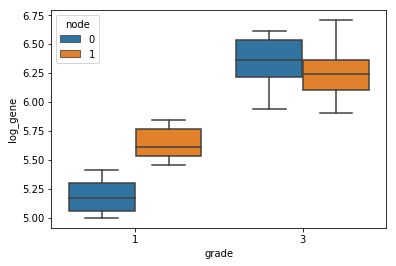

In [3]:
sns.boxplot(y="log_gene",x="grade",hue="node",data=gene_table)

In [4]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
formula = 'log_gene ~ C(grade) + C(node) + C(grade):C(node)'
lm = ols(formula, gene_table).fit()
#print(lm.summary())
print(anova_lm(lm))

                    df    sum_sq   mean_sq          F        PR(>F)
C(grade)           1.0  4.724248  4.724248  98.180646  3.691090e-09
C(node)            1.0  0.210704  0.210704   4.378918  4.934337e-02
C(grade):C(node)   1.0  0.432580  0.432580   8.989996  7.102512e-03
Residual          20.0  0.962358  0.048118        NaN           NaN


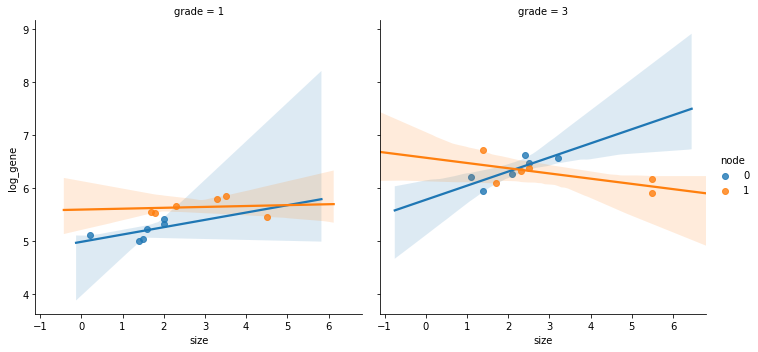

In [5]:
sns.lmplot(y="log_gene",x="size",hue="node",col="grade",data=gene_table)

In [6]:
formula = 'log_gene ~ C(grade) + C(node) + size'
lm2 = ols(formula, gene_table).fit()
print(anova_lm(lm2))

            df    sum_sq   mean_sq          F        PR(>F)
C(grade)   1.0  4.724248  4.724248  67.820058  7.427185e-08
C(node)    1.0  0.210704  0.210704   3.024817  9.736925e-02
size       1.0  0.001767  0.001767   0.025364  8.750601e-01
Residual  20.0  1.393171  0.069659        NaN           NaN


In [7]:
formula = 'log_gene ~ C(grade) + size + size:C(grade)'
lm3 = ols(formula, gene_table).fit()
print(anova_lm(lm3))

                 df    sum_sq   mean_sq          F        PR(>F)
C(grade)        1.0  4.724248  4.724248  81.016482  1.801068e-08
size            1.0  0.034664  0.034664   0.594460  4.497132e-01
size:C(grade)   1.0  0.404735  0.404735   6.940825  1.589141e-02
Residual       20.0  1.166244  0.058312        NaN           NaN
